# Benchmarking randomized circuits using Quantum state tomography

In [1]:
def benchmark_rc_circuit(original_circuit, randomized_circuits, measurement_qubits, backend, dpi=None):
    from qiskit_experiments.library import StateTomography
    from qiskit.quantum_info import DensityMatrix, state_fidelity, Statevector, partial_trace, purity
    from qiskit.visualization.utils import _bloch_multivector_data
    from qiskit.visualization.bloch import Bloch
    from matplotlib import pyplot as plt

    n = original_circuit.num_qubits
    density_matrices = []

    for circ in randomized_circuits:
        qstexp = StateTomography(circ, measurement_qubits=measurement_qubits)
        qstdata = qstexp.run(backend, shots=500).block_for_results()
        density_matrices.append(qstdata.analysis_results('state').value)

    bloch_data = [_bloch_multivector_data(density_matrix) for density_matrix in density_matrices]
    average_dm = DensityMatrix(sum([dm.data for dm in density_matrices]) / len(density_matrices))

    target_state = Statevector.from_instruction(original_circuit)
    target_dm = partial_trace(target_state, [i for i in range(n) if i not in measurement_qubits])
    fidelity_list = [state_fidelity(target_dm, dm) for dm in density_matrices]
    purity_list = [purity(dm) for dm in density_matrices]
    fidelity = state_fidelity(target_dm, average_dm)

    average_vectors = _bloch_multivector_data(average_dm)
    target_vectors = _bloch_multivector_data(target_dm)

    # Source code taken from https://qiskit.org/documentation/_modules/qiskit/visualization/state_visualization.html#plot_bloch_multivector
    num = len(bloch_data[0])
    width, height = plt.figaspect(1 / num)
    fig = plt.figure(figsize=(width, height), dpi=dpi)

    ax_list = [fig.add_subplot(1, num, i + 1, projection="3d") for i in range(num)]
    for i in range(num):
        B = Bloch(axes=ax_list[i])
        B.vector_width = 3
        B.vector_mutation = 5
        B.point_marker = ['o']
        B.point_size = [5]
        B.point_color = ['y']
        for j in range(len(randomized_circuits)):
            B.add_points(bloch_data[j][i], 'm')
        B.add_vectors(average_vectors[i])
        B.add_vectors(target_vectors[i])
        B.render()

    print(f'The blue arrow corresponds to the ideal result.')
    print(f'Fidelity of the red arrow: {fidelity}')
    print(f'Fidelity of the points: {fidelity_list}')
    print(f'Purities of the points: {purity_list}')

    return fig

In [64]:
def tvd_benchmark_rc_circuit(original_circuit, randomized_circuits, backend, shots_per_randomized_circuit = 500):
    from qiskit import execute
    from qiskit.quantum_info import Statevector

    n_random_circs = len(randomized_circuits)
    total_shots = n_random_circs * shots_per_randomized_circuit

    state_vector = Statevector.from_instruction(original_circuit)
    ideal_probabilities = state_vector.probabilities_dict()

    original_circuit.measure_all()
    bare_counts = execute(original_circuit, backend, shots=n_random_circs * shots_per_randomized_circuit).result().get_counts()
    bare_counts = {key: value for key, value in sorted(bare_counts.items())}
    original_circuit.remove_final_measurements()

    rc_counts_list = []
    for rc in randomized_circuits:
        rc.measure_all()
        rc_counts_list.append(execute(rc, backend, shots=shots_per_randomized_circuit).result().get_counts())
        rc.remove_final_measurements()
    keys = set().union(*rc_counts_list)
    rc_counts = {k: sum([cnts.get(k, 0) for cnts in rc_counts_list]) for k in keys}
    rc_counts = {key: value for key, value in sorted(rc_counts.items())}

    tvd_bare = sum(0.5 * abs(ideal_probabilities.get(key, 0) - bare_counts.get(key, 0) / total_shots)
                   for key in ideal_probabilities.keys() | bare_counts.keys())
    tvd_random = sum(0.5 * abs(ideal_probabilities.get(key, 0) - rc_counts.get(key, 0) / total_shots)
                     for key in ideal_probabilities.keys() | rc_counts.keys())

    print(ideal_probabilities)
    print(tvd_bare, bare_counts)
    print(tvd_random, rc_counts)

In [3]:
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass

# Code taken from https://quantumcomputing.stackexchange.com/questions/22149/replace-gate-with-known-identity-in-quantum-circuit
class RtoPauliTranslator(TransformationPass):
    def run(self, dag):
        """Run the pass."""

        # iterate over all operations
        for node in dag.op_nodes():

            if node.op.name in ["rx", "ry", "rz"]:
                # calculate the replacement
                replacement = QuantumCircuit(1)
                if node.op.name == "rx":
                    replacement.x(0)
                elif node.op.name == "ry":
                    replacement.y(0)
                else:
                    replacement.z(0)

                # replace the node with our new decomposition
                dag.substitute_node_with_dag(node, circuit_to_dag(replacement))

        return dag

In [50]:
def randomized_circuit(q_input, circ_number, max_iter):
    from qiskit.compiler import transpile
    from qiskit import QuantumCircuit
    import numpy as np

    ## define easy and hard gates

    easy_gate = ['x', 'y', 'z', 's']
    hard_gate = ['t', 'h', 'cz']
    basis_gate = easy_gate + hard_gate

    ## transpile the input gate to the equivalent gate with easy and hard gates basis

    q_transform = transpile(q_input, basis_gates=basis_gate)

    random_circuit_set = []

    for circ_ind in np.arange(circ_number):
        ## set easy_layer sets and hard_layer sets
        easy_layer = []
        hard_layer = []
        easy_layer_comp = []
        hard_seeker = False
        for gate in q_transform.data:
            if gate[0].name in hard_gate:
                hard_layer.append(gate)
                hard_seeker=True
                easy_layer.append(easy_layer_comp)
                easy_layer_comp=[]
            elif gate[0].name in easy_gate:
                if hard_seeker:
                    hard_seeker=False
                    easy_layer_comp=[]
                easy_layer_comp.append(gate)
        easy_layer.append(easy_layer_comp)

        def random_T():
            oper = QuantumCircuit(1, name='oper')
            rand_value = np.random.randint(4)
            if rand_value == 0:
                oper.x(0)
            elif rand_value == 1:
                oper.y(0)
            elif rand_value == 2:
                oper.z(0)
            return oper.to_instruction()

        depth_easy = len(easy_layer)
        depth_hard = len(hard_layer)
        depth = depth_easy+depth_hard

        T_set = []
        T_set.append([])
        for _ in range(depth_hard):
            T_comp = []
            for _ in np.arange(q_transform.num_qubits):
                T = random_T()
                T_comp.append(T)
            T_set.append(T_comp)
        T_set.append([])

        q_out = QuantumCircuit(q_transform.num_qubits)
        for ind in range(depth):
            if ind % 2 == 0:
                if ind > 2:
                    q_out.append(hard_layer[ind // 2 - 1][0].reverse_ops(), hard_layer[ind // 2 - 1][1])
                    for T_ind in np.arange(len(T_set[ind // 2])):
                        q_out.append(T_set[ind // 2][T_ind].reverse_ops(), [T_ind])
                    q_out.append(hard_layer[ind // 2 - 1][0], hard_layer[ind // 2 - 1][1])
                for sub_ind in np.arange(len(easy_layer[ind // 2])):
                    q_out.append(easy_layer[ind // 2][sub_ind][0], easy_layer[ind // 2][sub_ind][1])
                if ind != 0:
                    for T_ind in np.arange(len(T_set[ind // 2 + 1])):
                        q_out.append(T_set[ind // 2 + 1][T_ind], [T_ind])
                q_out.barrier()
            else:
                q_out.append(hard_layer[(ind - 1) // 2][0], hard_layer[(ind - 1) // 2][1])
                q_out.barrier()
        q_final = transpile(q_out, basis_gates=basis_gate + ['rz', 'ry', 'rx'], optimization_level=3)
        random_circuit_set.append(RtoPauliTranslator()(q_final))

    return random_circuit_set

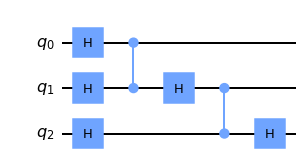

In [70]:
# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.compiler import transpile

target = QuantumCircuit(3)

target.h(0)
target.cx(0,1)
target.cx(1,2)

target = transpile(target, basis_gates=['h', 'cz', 'x', 'y', 'z', 't'])

rc_circs = randomized_circuit(target, 100, 1)

target.draw('mpl')

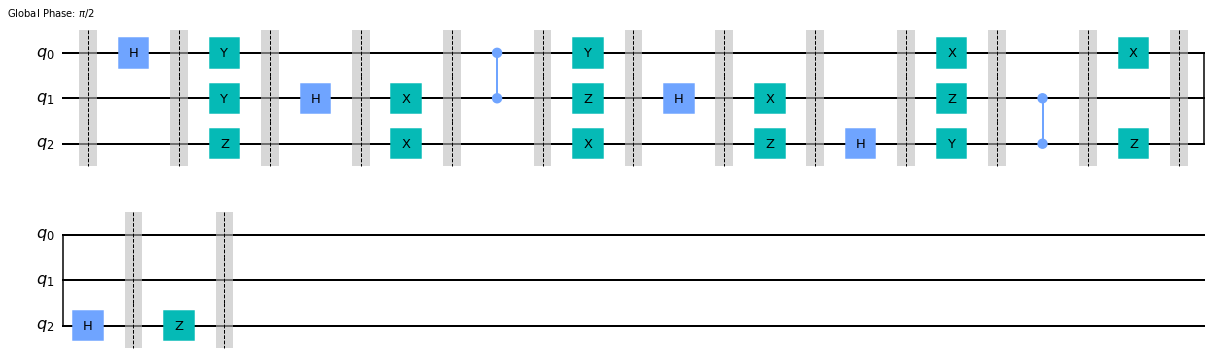

In [71]:
rc_circs[0].draw('mpl')

In [77]:
# Example error probabilities
p_reset = 0.001
p_meas = 0.001
p_gate1 = 0.001

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import pauli_error

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

backend = AerSimulator(noise_model=noise_bit_flip)

tvd_benchmark_rc_circuit(rc_circs[0], rc_circs, backend=backend, shots_per_randomized_circuit=10000)
# fig = benchmark_rc_circuit(target, rc_circs, measurement_qubits=[0, 1, 2], backend=backend, dpi=200)

{'000': 0.4999999999999996, '111': 0.4999999999999996}
0.02178299999999961 {'000': 489145, '001': 5472, '010': 1011, '011': 4366, '100': 4394, '101': 1056, '110': 5484, '111': 489072}
0.022054999999999606 {'000': 487885, '001': 5250, '010': 1864, '011': 3904, '100': 3936, '101': 1765, '110': 5336, '111': 490060}
